# Review for epsilon-greedy algorithm

### I. Epsilon-Decay Algorithm

- (1) The standard epsilon-greedy algorithm uses the fixed epsilon value over time. But the algorithm actually can figure out which options are really bad after some time. There is really no need to explore on these options any more. 
- (2) Design an algorithm that can adapt the epsilon value based on the time. Explore more in the earlier periods while exploit more in the later periods. 
- (3) Formula: epsilon = 1/(sum(self.counts)/len(self.counts)+1)
  - epsilon = 1/(1+beta*time_counts) (e.g., log transformation on the time counts)

### II. Disadvantages of the epsilon-greedy algorithm:
- (1) explorations are totally random
- (2) take longer to figure out the best arm
- (3) waste resources and money on the inferior options
- (4) adjust your explorations to be consistent with the reward rates of each arm you have figured out



# Softmax Algorithm

## 1. concepts

### 1.1. define the exploration probabilities
- (1) Structural explorations: explore the arms to their reward probabilities
- (2) the reward rate of arm A is rA, the reward rate of arm B is rB
- (3) $\frac{r_A}{(r_A+r_B)}, \frac{r_B}{(r_A+r_B)}$

- (4) select_arm(): 
  - $pi = \frac{one\_value}{sum\_values}$
  - current_choice = np.random.choice(n_arms, p=pi)
  - add exponential functions to rescale (e.g., negative number on reward values)
  - $pi = \frac{exp(one\_value)}{sum(exp(one\_value))}$
  - temperature parameter (scaling factor)
  
  - $pi = \frac{exp(\frac{one\_value}{tau})}{sum(exp(\frac{one\_value}{tau}))}$
  
### 1.2. interpretations for temperature parameter

- (1) $pi$ denotes the probability of choosing one arm in one trial
- (2) the temperature term is derived from the concept in physics that use Boltzmann distribution to describe the particles' movement. When the temperature is higher, particles behave more randomly, while when it's lower, the particles take a more stable structure. 
- (3) when tau is larger, explorations are more random. Whereas, when tau is smaller (tau--> 0), the actions will bias towards a greedy exploitative strategy. 
  

In [13]:
## import necessary packages
import random
import math
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


In [14]:
class Softmax():
    
    def __init__(self,temperature,counts, values):
        self.temperature = temperature
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        z=sum([math.exp(v/self.temperature) for v in self.values])
        probs=[math.exp(v/self.temperature)/z for v in self.values]
        current_choice = np.random.choice(n_arms, p=probs)
        return current_choice
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return
        

In [15]:
## define the class of arms
class GaussianArm():
    def __init__(self, mu):
        self.mu = mu
    
    def draw(self):
        return np.random.normal(self.mu, 1)


In [16]:
## define test_algorithm
def test_algorithm (algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize (len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t -1 
            sim_nums[index] = sim
            times[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]
            

In [18]:
## simulation and test on softmax
import pandas as pd
import os
random.seed(4014)
suffix = "_softmax_gaussian_s1000_s500_std01"
output = ("simulate"+suffix+".csv")

# initialization, arms
n_arms = 10
mus = np.random.normal(0, 0.1, n_arms) # [1,3, 4,...]
print ("The arm with the highest mean value is {}".format(np.argmax(mus)))
arms = list(map(lambda mu: GaussianArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 1000 
N_STEPS = 500 # number of users
overall_count = 0

for temperature in [0.01, 0.5]:
    algo = Softmax(temperature, [], [])
    algo.initialize(n_arms)
    results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
    results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
    results['temperature'] = temperature
    if overall_count == 0:
        results.to_csv(output, index = False)
    else:
        results.to_csv(output, index = False, mode='a',header=None)
    overall_count=overall_count + 1


The arm with the highest mean value is 5


(1000000, 7)
   n_sim  n_step  chosen_arm   rewards  cumulative_rewards  temperature  \
0    1.0     1.0         3.0  1.553114            1.553114         0.01   
1    1.0     2.0         3.0  0.159947            1.713061         0.01   

   if_best_arm  
0            0  
1            0  
['n_sim', 'n_step', 'chosen_arm', 'rewards', 'cumulative_rewards', 'temperature', 'if_best_arm']


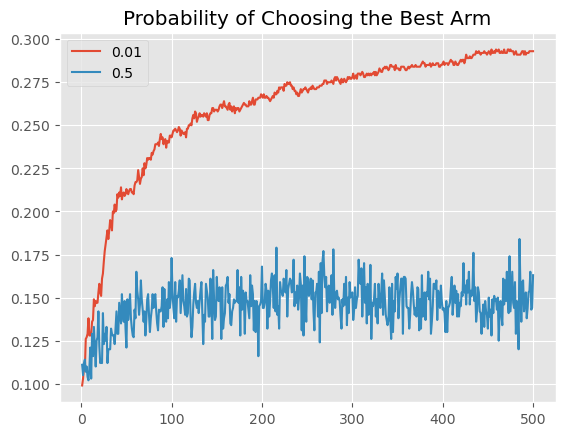

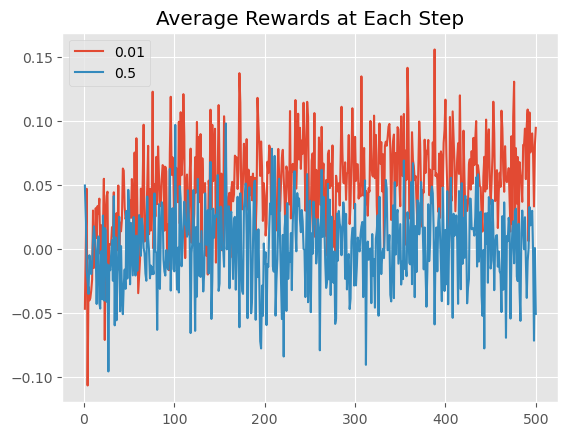

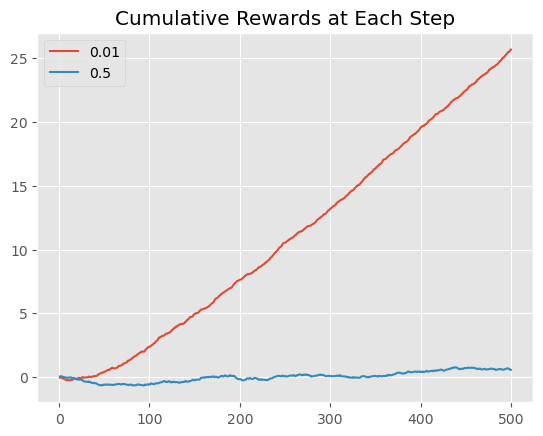

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

suffix = "_softmax_gaussian_s1000_s500_std01"
output = ("simulate"+suffix+".csv")
all_results = pd.read_csv(output)
all_results ['if_best_arm'] = np.where(all_results['chosen_arm']==np.argmax(mus), 1,0)
# all_results = all_results[all_results['n_step']<101]
print(all_results.shape)
print(all_results.iloc[:2,])
print(all_results.columns.values.tolist())

results_plot = all_results.groupby(['temperature','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure()
ax = fig.add_subplot(111)
for temperature in results_plot['temperature'].unique():
    ax.plot(results_plot[results_plot['temperature']==temperature]['n_step'],results_plot[results_plot['temperature']==temperature]['if_best_arm'], label=str(temperature))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure()
ax = fig.add_subplot(111)
for temperature in results_plot['temperature'].unique():
    ax.plot(results_plot[results_plot['temperature']==temperature]['n_step'],results_plot[results_plot['temperature']==temperature]['rewards'], label=str(temperature))
plt.legend()
plt.title('Average Rewards at Each Step')
plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure()
ax = fig.add_subplot(111)
for temperature in results_plot['temperature'].unique(): 
    ax.plot(results_plot[results_plot['temperature']==temperature]['n_step'],results_plot[results_plot['temperature']==temperature]['cumulative_rewards'], label=str(temperature))
plt.legend()
plt.title('Cumulative Rewards at Each Step')
plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)

## 2. Annealing Softmax

- (1) temperature = 1/(1+beta*n)
  - temperature = 1/(1+log(n+1e04))

In [20]:
class AnnealingSoftmax():
    
    def __init__(self,counts, values):
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return
        
    def select_arm(self):
        temperature = 1/(1+math.log(sum(self.counts)+0.000001))
        z=sum([math.exp(v/temperature) for v in self.values])
        probs=[math.exp(v/temperature)/z for v in self.values]
        current_choice = np.random.choice(n_arms, p=probs)
        return current_choice
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return
        

In [21]:
## simulation and test on softmax
import pandas as pd
import os
random.seed(4014)
suffix = "_softmaxannealing_gaussian_s1000_s500_std01"
output = ("simulate"+suffix+".csv")

# initialization, arms
# n_arms = 10
# mus = np.random.normal(0, 0.1, n_arms) # [1,3, 4,...]
# print ("The arm with the highest mean value is {}".format(np.argmax(mus)))
# arms = list(map(lambda mu: GaussianArm(mu), mus))

# initialization, arguments
N_SIMULATIONS = 1000
N_STEPS = 500

algo = AnnealingSoftmax([], [])
algo.initialize(n_arms)
results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, N_STEPS)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['temperature'] = "annealing"

results.to_csv(output, index = False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

suffix = "_softmax_gaussian_s1000_s500_std01"
output = ("simulate"+suffix+".csv")
softmax_results = pd.read_csv(output)
suffix = "_softmaxannealing_gaussian_s1000_s500_std01"
output = ("simulate"+suffix+".csv")
annealing_results = pd.read_csv(output)
all_results = pd.concat([softmax_results, annealing_results])

all_results ['if_best_arm'] = np.where(all_results['chosen_arm']==np.argmax(mus), 1,0)
# all_results = all_results[all_results['n_step']<101]
print(all_results.shape)
print(all_results.iloc[:2,])
print(all_results.columns.values.tolist())

results_plot = all_results.groupby(['temperature','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})
plt.style.use('ggplot')

# plot for the best arm
fig = plt.figure()
ax = fig.add_subplot(111)
for temperature in results_plot['temperature'].unique():
    ax.plot(results_plot[results_plot['temperature']==temperature]['n_step'],results_plot[results_plot['temperature']==temperature]['if_best_arm'], label=str(temperature))
plt.legend()
plt.title('Probability of Choosing the Best Arm')
plt.savefig('best_arms'+suffix+'.png', dpi=300)

# plot for average rewards
fig = plt.figure()
ax = fig.add_subplot(111)
for temperature in results_plot['temperature'].unique():
    ax.plot(results_plot[results_plot['temperature']==temperature]['n_step'],results_plot[results_plot['temperature']==temperature]['rewards'], label=str(temperature))
plt.legend()
plt.title('Average Rewards at Each Step')
plt.savefig('avg_rewards'+suffix+'.png', dpi=300)

# plot for cumulative rewards
fig = plt.figure()
ax = fig.add_subplot(111)
for temperature in results_plot['temperature'].unique(): 
    ax.plot(results_plot[results_plot['temperature']==temperature]['n_step'],results_plot[results_plot['temperature']==temperature]['cumulative_rewards'], label=str(temperature))
plt.legend()
plt.title('Cumulative Rewards at Each Step')
plt.savefig('cumulative_rewards'+suffix+'.png', dpi=300)